# U_net recreation 

## Purpose: Recreate U_net architecture according to the original paper. Adjust the architecture to run on a laptop with a single NVIDIA RTX 3060 (laptop). Train the adjusted the model on "TGS Salt Identification Challenge" and make inferences. Upload the best model to Github 

## Introduction: U_net is a popular image segmentation model. Recently, the model is used for denoising in deffusion models. The model consist of various contracting layers and expanding layers making up a U shape. The number of feature channels of an image is doubled for each contracting layer and halved for each expanding layer. A classifier layer return the number of feature layer according to the number of classification needed.

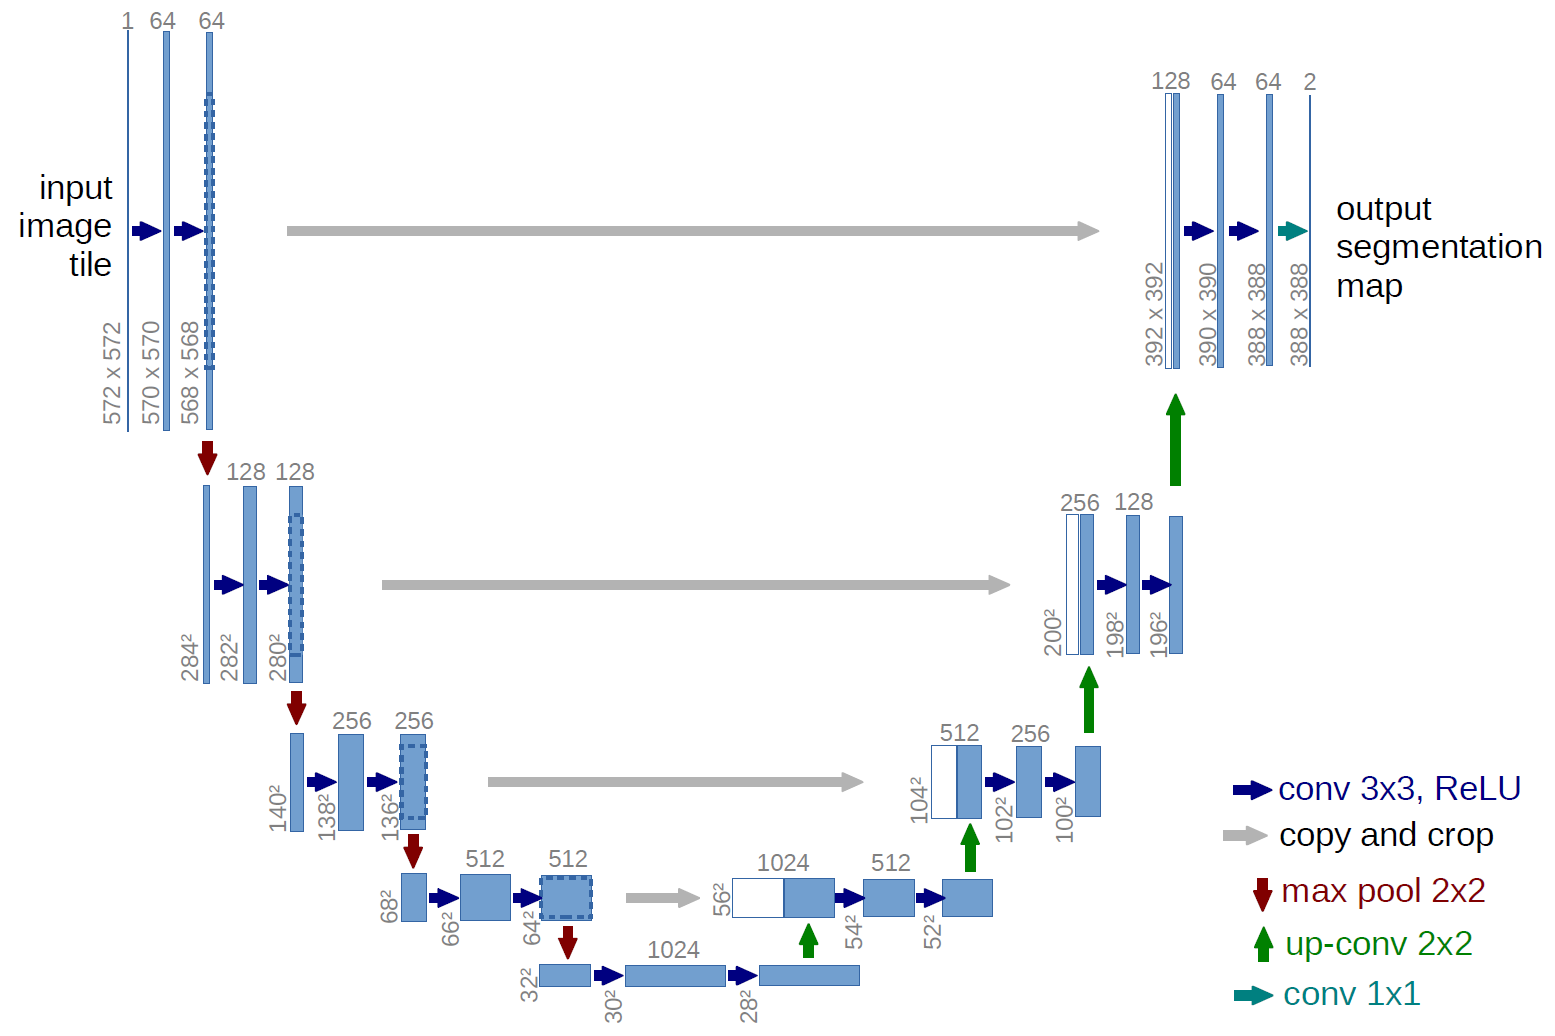

## Method:

#### 1. Import dependencies and set up device diagnostic

In [55]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
from pathlib import Path
import os
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import glob
import shutil
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader

import torch.nn.functional as F
import lightning as L

In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### 2. Create the data set. The "TGS Salt Identification Challenge" data set is from downloaded from Kaggle. The folder is organized into 2 folders: "train" and "validation". The "train" folder has 2 folders: "images" and "masks" containing RGB 101x101 images and their corresponding masked image. The "validation" folder contain only an "images" folder.

##### I want to split the images and their respective masks into a "train" and a "validation" group since the existing "validation"folder contain no mask images to evaluate our model. 

In [57]:
# Set up path to data directory
data_directory_path = Path("C:/Users/nemol/U_net_recreation/data")
data_directory_path

WindowsPath('C:/Users/nemol/U_net_recreation/data')

Random image path: C:\Users\nemol\U_net_recreation\data\test\images\94ca0e01a0.png
Image height: 101
Image width: 101


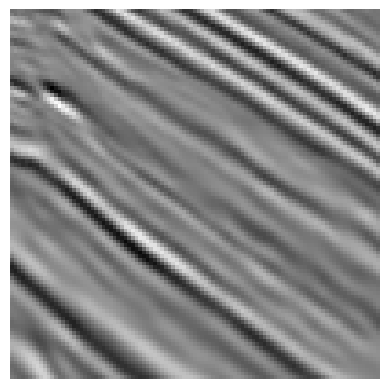

In [58]:
# 1.Get all image paths
image_path_list = list(data_directory_path.glob("*/*/*.png"))

# 2.Get random image path
random_image_path = random.choice(image_path_list)

# 3. Open image
img = cv2.imread(str(random_image_path))

# 4. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image height: {img.shape[0]}") 
print(f"Image width: {img.shape[1]}")
plt.axis("off")
plt.imshow(img)

In [59]:
# Create function to get a percentage of data
def get_subset(target_directory_path,
               data_splits=["train", "validation"],
               amount=0.05,
               seed=47):
    random.seed(seed)
    image_dictionary= {}
    print(f"[INFO] Creating image split for: {data_splits[0]}...")
    image_paths = glob.glob(os.path.join(target_directory_path, 'images','*.png'))
    
    # Get a random samples pool of the amount specified for the train split
    number_to_sample = round(amount*len(image_paths))
    print(f"[INFO] Getting random subset of {number_to_sample} image pairs for {data_splits[0]}...")
    sampled_images = random.sample(image_paths, k=number_to_sample)
    sampled_masks=[]
    for image_path in sampled_images:
        sampled_masks.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
        image_paths.remove(image_path)
    image_dictionary["train"] = sampled_images + sampled_masks
    
    # Get the remaining sample for the validation split
    print(f"[INFO] Creating image split for: {data_splits[1]}...")
    number_to_sample = len(image_paths)
    print(f"[INFO] Getting random subset of {number_to_sample} image pairs for {data_splits[1]}...")
    sampled_images = image_paths
    sampled_masks=[]
    for image_path in sampled_images:
        sampled_masks.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
    image_dictionary["validation"] = sampled_images + sampled_masks
    
    return image_dictionary

In [60]:
# Function to make a directory
def make_directory(file_destination:int,
                   file_name:int):
    # Create target directory path
    target_dir_name = f"{file_destination}/{file_name}"
    print(f"Creating directory: '{target_dir_name}'")

    # Setup the directories
    target_dir = Path(target_dir_name)

    # Make the directories
    target_dir.mkdir(parents=True, exist_ok=True)
    
    return target_dir

In [61]:
# Function to split a dictionary of image paths into sperate files of train and validation. Within train and validation the images are split into masks and images.
def split_images_into_files(subset_image_pair_paths:Dict,
                            target_directory:Path):
    for image_split in subset_image_pair_paths.keys():
        for image_path in subset_image_pair_paths[str(image_split)]:
            image_path=Path(image_path)
            dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
            if not dest_dir.parent.is_dir():
                dest_dir.parent.mkdir(parents=True, exist_ok=True)
            print(f"[INFO] Copying {image_path} to {dest_dir}...")
            shutil.copy2(image_path, dest_dir)

In [62]:
# 1. Create a custom dataset class to load the segmentation data folder. Subclass of torch.utils.data.Dataset
class SegmentationDataSet (torch.utils.data.Dataset):
    # 2. Initialize with a target directory path (train or validation) and transform parameter
    def __init__(self, target_directory_path:str, transform=None):
        super().__init__()
        # 3. Create class attributes
        # Get image paths from images folder
        self.image_paths = glob.glob(os.path.join(target_directory_path, 'images','*.png'))
        # self.image_paths = list(Path(target_directory_path)/"images".glob("*.png"))
        # Set up transforms
        self.transform=transform
        # Get a list of masks paths that match the image paths
        self.mask_paths = []
        for image_path in self.image_paths:
            self.mask_paths.append(os.path.join(target_directory_path,'masks',os.path.basename(image_path)))
    # 4. Make function to load original image and masked image
    def load_image(self, index:int) -> Image.Image:
        "Open an original image and the corresponding masked image and return it."
        original_image_path = self.image_paths[index]
        image = cv2.imread(original_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[index], 0)
        return image, mask
    # 5. Overwrite the len function to return the number of image pairs
    def __len__(self) -> int:
        return len(self.image_paths)
    # 6. Overwrite the __getitem__() method
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, torch.Tensor]:
        original_image, masked_image = self.load_image(index)
        # Transform if necessary
        if self.transform:
            return self.transform(original_image), self.transform(masked_image) # return transformed original and masked image pair
        else:
            return original_image, masked_image # return original and masked image pair

In [63]:
# Set up train directory path
global_train_directory = data_directory_path / "raw" / "train"

In [ ]:
# Split the images and masks in the original train folder into an 80/20 split of train and validation
L.seed_everything(42)
subset_image_pair_paths_80 = get_subset(target_directory_path=global_train_directory,
                        amount=0.8)
target_dir = data_directory_path
split_images_into_files(subset_image_pair_paths=subset_image_pair_paths_80,
                        target_directory=target_dir)

In [64]:
# Compose image transformation with minimal resizing of original image size
data_transform_min_alt = transforms.Compose([
    transforms.ToPILImage(),
    # Resize image to match the input image size of the U_net paper
    transforms.Resize(size=(104, 104)),
    # Turn image to tensor
    transforms.ToTensor()
])


In [65]:
# Set up train and validation directory path
train_directory = data_directory_path / "train"
validation_directory= data_directory_path / "validation"

train_directory, validation_directory

(WindowsPath('C:/Users/nemol/U_net_recreation/data/train'),
 WindowsPath('C:/Users/nemol/U_net_recreation/data/validation'))

In [66]:
# Create segmentation dataset for the train and validation data
train_data= SegmentationDataSet(target_directory_path=train_directory,
                                           transform=data_transform_min_alt)
validation_data = SegmentationDataSet(target_directory_path=validation_directory,
                                           transform=data_transform_min_alt)
len(train_data), len(validation_data)

(3200, 800)

In [67]:
# Create dataloaders of the train and validation segmentation dataset
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=40,
                              num_workers=0)
validation_dataloader = DataLoader(dataset=validation_data,
                              batch_size=40,
                              num_workers=0)
len(train_dataloader), len(validation_dataloader)

(80, 20)

Now the data is set up and ready for training

#### 3. Recreate the original U_net model from the "U-Net: Convolutional Networks for Biomedical Image Segmentation" paper. Scale down the model and create 3 variations for validationing.

##### Recreate the original U_net architecture by initializing each contracting and expanding layer. This results in a model with a very lengthy __init__ method. This version also requires a lot of calculations by hand making it slow to expand or reduce.

In [68]:
# Create U_net_original class that inherit from nn.Module
class U_net_original(nn.Module):
    """Straight forward U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        input_shape: int = 1,  # Number of feature channels of the input image
        first_layer_feature_channels: int = 64,  # Number of feature channels of the first layer
        second_layer_feature_channels: int = 128,  # Number of feature channels of the second layer
        third_layer_feature_channels: int = 256,  # Number of feature channels of the third layer
        fourth_layer_feature_channels: int = 512,  # Number of feature channels of the fourth layer
        fifth_layer_feature_channels: int = 1024,  # Number of feature channels of the fifth layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1,  # Kernel size for the final classification step
        output_feature: int = 2,  # Number of output features
    ):
        super().__init__()
        self.maxpool_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.contracting_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.contracting_layer_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.expanding_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fifth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fifth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=fifth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=fourth_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=fourth_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=third_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=third_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=third_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=second_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=second_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=up_conv_kernel_size,
                stride=up_conv_kernel_size,
            ),
        )
        self.expanding_layer_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=second_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=first_layer_feature_channels,
                out_channels=first_layer_feature_channels,
                kernel_size=conv_kernel_size,
            ),
            nn.ReLU(),
        )
        self.classifier = nn.Conv2d(
            in_channels=first_layer_feature_channels,
            out_channels=output_feature,
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        image_size_before_first_up_conv = (x.shape[2] / 16) - 7.75
        x = self.contracting_layer_1(x)
        cropped_x_layer_1 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 16 - 56
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_2(x)
        cropped_x_layer_2 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 8 - 24
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_3(x)
        cropped_x_layer_3 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 4 - 8
        )(x)
        x = self.maxpool_layer(x)
        x = self.contracting_layer_4(x)
        cropped_x_layer_4 = transforms.CenterCrop(
            size=image_size_before_first_up_conv * 2
        )(x)
        x = self.maxpool_layer(x)
        x = self.expanding_layer_1(x)
        x = self.expanding_layer_2(torch.cat((x, cropped_x_layer_4), 1))
        x = self.expanding_layer_3(torch.cat((x, cropped_x_layer_3), 1))
        x = self.expanding_layer_4(torch.cat((x, cropped_x_layer_2), 1))
        x = self.expanding_layer_5(torch.cat((x, cropped_x_layer_1), 1))
        x = self.classifier(x)
        return x

In [ ]:
# Get a summary of the original model
sample_model = U_net_original(input_shape=1, output_feature=2)
summary(
    model=sample_model,
    input_size=(10, 1, 572, 572),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

##### Recreate a simplified version of the original U_net architecture by initializing a double convolution layer for the contracting path, a double convolution layer for the expanding path, a maxpool layer, an up convolution layer, and a classifier layer. This results in a model with a more compact __init__ and forward method. This version is also easier to scale up or down so I will use this for scaling down.

In [69]:
class U_net_original_simplified(nn.Module):
    """More compact recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(1, 64, 128, 256, 512, 1024), # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(1024, 512, 256, 128, 64, 2), # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1 # Kernel size for the final classification step
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x

In [ ]:
# Get a summary of the original model
sample_model = U_net_original_simplified()
summary(
    model=sample_model,
    input_size=(10, 1, 572, 572),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

##### Create 3 smaller versions of U_net to improve run time on a single GPU. I also convert the model class to be a subclasss of the Lightning Module for more efficient experiementation.

For V1, I reduce the total number of layers from 6 to 4 and reduce the total feature channels per layer

In [70]:
class U_net_reducedV1(L.LightningModule):
    """A down-sized verison of the original model with 4 layers.

    The number of feature channels also was reduced to a maximum of 64 channels.
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64),  # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(64, 32, 16, 1),  # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1,  # Kernel size for the final classification step
    ):
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = transforms.CenterCrop(size=x.shape[2])(
                    images_to_be_concat[-i]
                )
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x

    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        y = transforms.CenterCrop(size=logits.shape[2])(y)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log("train_loss", loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        y = transforms.CenterCrop(size=logits.shape[2])(y)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log("val_loss", loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001, weight_decay=0.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer, factor=0.1, patience=20, threshold=0.01, verbose=True
                ),
                "monitor": "train_loss",
                "frequency": 1,
            },
        }

In [ ]:
# Get a summary of the reducedV1 model
sample_model = U_net_reducedV1()
summary(
    model=sample_model,
    input_size=(10, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

For V2, I reduce the total number of layers from 6 to 4 and reduce the total feature channels per layer. I also added padding to each of the Conv2d layer to preserve the image size. As a results, no cropping was needed for the concatinating steps.

In [71]:
class U_net_reducedV2(L.LightningModule):
    """More readable recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64), # Number of feature channels of each of the contracting layer
        expanding_layer_feature_channels=(64, 32, 16, 1), # Number of feature channels of each of the expanding layer
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1, # Kernel size for the final classification step
        padding: int=1 # Padding to preserve image size
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = images_to_be_concat[-i]
            
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = images_to_be_concat[-i]

                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x
    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('val_loss', loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0001, weight_decay=.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=20, threshold=.01, verbose=True),
            "monitor": "train_loss",
            "frequency": 1},
        }

In [ ]:
# Get a summary of the reducedV2 model
sample_model = U_net_reducedV2()
summary(
    model=sample_model,
    input_size=(10, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

For V3, I reduce the total number of layers from 6 to 5 and reduce the total feature channels per layer. (V3 has an extra layer compared to V1 and V2). I also added padding to each of the Conv2d layer to preserve the image size. As a results, no cropping was needed for the concatinating steps.

In [72]:
class U_net_reducedV3(L.LightningModule):
    """More readable recreation of the U-net architecture with hyperparameters described in the paper by default.

    Takes a gray scale image and return 2 channels image: an outline mask layer and an object mask layer
    """

    def __init__(
        self,
        contracting_layer_feature_channels=(3, 16, 32, 64, 128),
        expanding_layer_feature_channels=(128, 64, 32, 16, 1),
        conv_kernel_size: int = 3,  # Kernel size of the convolutional step
        up_conv_kernel_size: int = 2,  # Kernel size for the transposed convolutional step
        maxpool_kernel_size: int = 2,  # Kernel size for the maxpool step
        final_conv_kernel_size: int = 1, # Kernel size for the final classification step
        padding: int=1 # Padding to preserve image size
    ):  
        super().__init__()
        self.contracting_layer_feature_channels = contracting_layer_feature_channels
        self.expanding_layer_feature_channels = expanding_layer_feature_channels
        self.double_conv_layers_down = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=contracting_layer_feature_channels[i + 1],
                        out_channels=contracting_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.contracting_layer_feature_channels) - 1)
            ]
        )

        self.double_conv_layers_up = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=expanding_layer_feature_channels[i + 1],
                        out_channels=expanding_layer_feature_channels[i + 1],
                        kernel_size=conv_kernel_size,
                        padding=padding,
                        padding_mode="reflect"
                    ),
                    nn.ReLU(),
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.contracting_layer = nn.MaxPool2d(
            kernel_size=maxpool_kernel_size, stride=maxpool_kernel_size
        )
        self.expanding_layer = nn.ModuleList(
            [
                nn.ConvTranspose2d(
                    in_channels=self.expanding_layer_feature_channels[i],
                    out_channels=self.expanding_layer_feature_channels[i + 1],
                    kernel_size=up_conv_kernel_size,
                    stride=up_conv_kernel_size,
                )
                for i in range(len(self.expanding_layer_feature_channels) - 2)
            ]
        )
        self.classifier = nn.Conv2d(
            in_channels=self.expanding_layer_feature_channels[-2],
            out_channels=self.expanding_layer_feature_channels[-1],
            kernel_size=final_conv_kernel_size,
        )

    def forward(self, x: torch.Tensor):
        images_to_be_concat = []
        for i in range(len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                x = self.double_conv_layers_down[i](x)
                images_to_be_concat.append(x)
                x = self.contracting_layer(x)
            else:
                x = self.double_conv_layers_down[i](x)
                x = self.expanding_layer[0](x)
        for i in range(1, len(self.contracting_layer_feature_channels) - 1):
            if i != (len(self.contracting_layer_feature_channels) - 2):
                image_to_be_concat = images_to_be_concat[-i]
            
                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.expanding_layer[i](x)
            else:
                image_to_be_concat = images_to_be_concat[-i]

                x = self.double_conv_layers_up[i - 1](
                    torch.concat((x, image_to_be_concat), 1)
                )
                x = self.classifier(x)
        return x
    def binary_cross_entropy_with_logits(self, logits, labels):
        return nn.functional.binary_cross_entropy_with_logits(logits, labels)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.binary_cross_entropy_with_logits(logits, y)
        self.log('val_loss', loss, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=.0001, weight_decay=.0001)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1, patience=20, threshold=.01, verbose=True),
            "monitor": "train_loss",
            "frequency": 1},
        }

In [ ]:
# Get a summary of the reduceV3 model
sample_model = U_net_reducedV3()
summary(
    model=sample_model,
    input_size=(25, 3, 104, 104),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)

#### 4. Train the model with pytorch lightning

| Version # | Model | Optimizer | Epochs | Learning rate | weight decay | Lr_scheduler | Monitor | Factor | Patience | Threshold | 
|:--------: |:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|   0   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   1   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   2   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   3   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   4   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   5   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  Val_loss  |  0.1   |  20   |  0.01   |
|   6   |  U_net_reducedV1  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   7   |  U_net_reducedV2  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   8   |  U_net_reducedV3  |  Adam  |  200   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   9   |  U_net_reducedV1  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   10   |  U_net_reducedV2  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   11   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   12   |  U_net_reducedV1  |  Adam  |  450   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   13   |  U_net_reducedV2  |  Adam  |  450   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   14   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   15   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0005   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   16   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0003   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   17   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   18   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.00015   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |0
|   19   |  U_net_reducedV3  |  Adam  |  500   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   20   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
|   21   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0003   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   |
Padded mode: reflection (version 22-24)
|   22   |  U_net_reducedV3  |  Adam  |  300   |  0.0001   |   0.0002   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 
|   23   |  U_net_reducedV3  |  Adam  |  500   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 
|   24   |  U_net_reducedV3  |  Adam  |  1000   |  0.0001   |   0.0001   |  Plateau   |  train_loss  |  0.1   |  20   |  0.01   | 

In [ ]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=450)
modelV1 = U_net_reducedV1()
trainer.fit(model=modelV1, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

In [ ]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=450)
modelV2 = U_net_reducedV2()
trainer.fit(model=modelV2, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

In [ ]:
L.seed_everything(42, workers=False)
trainer = L.Trainer(max_epochs=1000)
modelV3 = U_net_reducedV3()
trainer.fit(model=modelV3, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

## Results

Visualize the loss curves. Load the best model(s) and plot images from validation dataset to visualize the predictions. Time the inference to find the differences between the two best models.

In [73]:
# Plot 3 random images, mask predictions and actual mask from the validation dataset
def plot_prediction_and_actual(data_set:torch.utils.data.Dataset,
                               model:torch.nn.Module,
                               output_img_size:int):
    # Get 3 random image indexes
    random_image_index = random.sample(range(len(data_set)), k=3)

    # Set up plot
    plt.figure(figsize=(5, 4))

    # Loop through samples and display them
    for sample_image in random_image_index:
        fig, ax = plt.subplots(1, 3)
        org_img, masked_img = data_set[sample_image][0], data_set[sample_image][1]
        cropped_masked_img = transforms.CenterCrop(size=(output_img_size,output_img_size))(data_set[sample_image][1])
        
        # Pass the image through the model
        org_img = org_img.unsqueeze(dim=0)
        model.eval()
        with torch.inference_mode():
            prediction = model(org_img.to(device))
        prediction = prediction.to("cpu")
        prediction = torch.round(torch.sigmoid(prediction.squeeze(dim=0)))
        
        # Permute the image to display
        org_img = org_img.squeeze(dim=0).permute(1, 2, 0)
        permuted_prediction = prediction.permute(1, 2, 0)
        permuted_masked_img = cropped_masked_img.permute(1, 2, 0)
        
        # Plot image on the right
        ax[0].imshow(org_img)
        ax[0].axis("off")
        ax[0].set_title(f"Image")
        
        # Plot predicted mask image in the middle
        ax[1].imshow(permuted_prediction)
        ax[1].axis("off")
        ax[1].set_title(f"Prediction mask")
        
    
        # Plot actual mask image on the right
        ax[2].imshow(permuted_masked_img)
        ax[2].axis("off")
        ax[2].set_title(f"Actual mask")

Visualize the loss curves of the experiements using Tensorboard

In [74]:
# OpenTensorboard
%load_ext tensorboard
%tensorboard --logdir C:/Users/nemol/U_net_recreation/lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 26348), started 0:49:34 ago. (Use '!kill 26348' to kill it.)

Version_9 and Version_23 are the best performing. I loaded the models from their checkpoints and pass 3 images through the models. I then visually compared the prediction mask and the actual mask.

In [75]:
version_9 = U_net_reducedV1.load_from_checkpoint("C:/Users/nemol/U_net_recreation/lightning_logs/version_9/checkpoints/epoch=299-step=24000.ckpt")

In [76]:
version_23 = U_net_reducedV3.load_from_checkpoint("C:/Users/nemol/U_net_recreation/lightning_logs/version_23/checkpoints/epoch=499-step=40000.ckpt")

Seed set to 45


<Figure size 500x400 with 0 Axes>

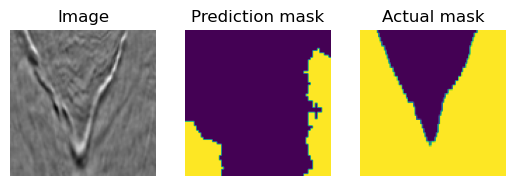

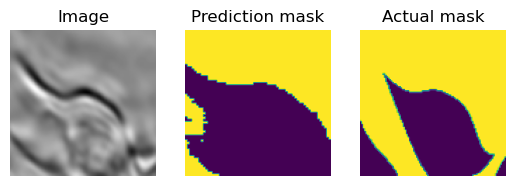

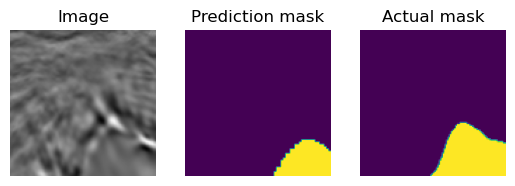

In [78]:
L.seed_everything(45)
plot_prediction_and_actual(data_set=validation_data,
                           model=version_9,
                           output_img_size=104)

Seed set to 45


<Figure size 500x400 with 0 Axes>

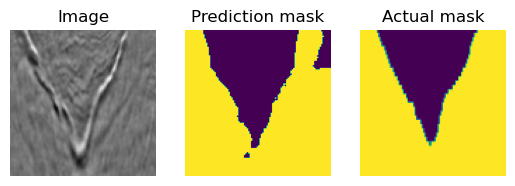

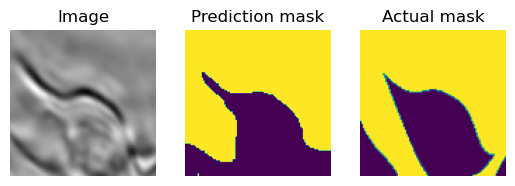

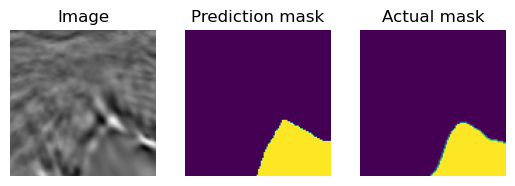

In [79]:
L.seed_everything(45)
plot_prediction_and_actual(data_set=validation_data,
                           model=version_23,
                           output_img_size=104)

I compared the difference in inference time of the two model as verison_9 contain less parameters than version_13

In [80]:
random_tensor = torch.rand((1, 3, 104, 104))

In [81]:
%%timeit
version_9.eval()
with torch.inference_mode():
    version_9(random_tensor.to(device))

1.11 ms ± 21.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%%timeit
version_23.eval()
with torch.inference_mode():
    version_23(random_tensor.to(device))

1.63 ms ± 31.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
